In [21]:
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as Fu
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from unet_val import UNet
import torch.backends.cudnn as cudnn
from IOU_computations import *
from shapeSorter import SimpleSegmentationDataset
import os
from image_utils import standardize

In [22]:
##########
GLOBAL_PATH='MODEL_SHAPE_PYTORCH/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=3
OUTPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'pytorch_shape'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=2000#2000
DROPOUT=1.0#0.9
DEFAULT_BATCH_SIZE = 8#8
DEFAULT_EPOCHS = 20#300
DEFAULT_ITERATIONS =618#618
DEFAULT_VALID=10#100
DISPLAY_STEP=100#100

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_LR=0.0001

####### TMP folder for IOU

TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)

In [23]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
 
    
    def _initialize(self, prediction_path):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        
        self.prediction_path = prediction_path
        
    
    def train(self, data_provider_path, save_path='', restore_path='', training_iters=4, epochs=3, dropout=0.9, display_step=1, validation_batch_size=30,rec_save=1, prediction_path = ''):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        
        PATH_TRAINING=data_provider_path+'TRAINING/'
        PATH_VALIDATION=data_provider_path+'VALIDATION/'
        PATH_TEST=data_provider_path+'TEST/'
        
        loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,training_iters,TEST_SAVE,'a')
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        self._initialize(prediction_path)
            
        if restore_path=='':
            print('Model trained from scratch')
        else:            
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))
            
            

        val_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=validation_batch_size)
        X_val,Y_val=val_generator.__getitem__()
        X_val=standardize(X_val)
        
        self.store_validation(X_val, Y_val, "_init",validation_batch_size,save_patches=True)

        train_len = self.batch_size*training_iters
        training_generator=SimpleSegmentationDataset(SIZE_PATCH,NB_CLASSES,virtual_size=train_len)
        X_train,Y_train=training_generator.__getitem__()
        
        
        logging.info("Start optimization")

        counter=0
        for epoch in range(epochs):
            total_loss = 0


            for step in range((epoch*training_iters), ((epoch+1)*training_iters)):

                step_batch=step-(epoch*training_iters)
                batch_x= X_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
                batch_x=standardize(batch_x)
                batch_y =Y_train[step_batch*self.batch_size:(step_batch+1)*self.batch_size]
                prediction,loss=self.predict(batch_x,batch_y)
                # Run optimization op (backprop)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()


                if step % display_step == 0:
                    self.output_minibatch_stats(step, batch_x,batch_y)

                total_loss += loss.data[0]
                loss_train[counter]=loss
                file_train.write(str(loss_train[counter])+'\n')
                counter += 1
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))



            self.output_epoch_stats(epoch, total_loss, training_iters, self.lr)
            loss_v,prediction_v=self.store_validation( X_val, Y_val, "epoch_%s"%epoch,validation_batch_size,save_patches=False)
            iou_acc_v,f1_v,iou_v=predict_score_batch(TMP_IOU,Y_val[:,:,:,0],1-np.argmax(prediction_v,3))
            
            
            IOU_verif[epoch]=iou_v
            IOU_acc_verif[epoch]=iou_acc_v
            f1_IOU_verif[epoch]=f1_v
            loss_verif[epoch]=loss_v
            
            IOU_file_verif.write(str(IOU_verif[epoch])+'\n')
            IOU_acc_file_verif.write(str(IOU_acc_verif[epoch])+'\n')
            f1_IOU_file_verif.write(str(f1_IOU_verif[epoch])+'\n')
            file_verif.write(str(loss_verif[epoch])+'\n')
            
            print("Validation IoU {:.4f}%, Validation IoU_acc {:.4f}%,Validation F1 IoU {:.4f}%".format(iou_v,iou_acc_v,f1_v))
            
            
        torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
        loss_v=self.store_validation( X_val, Y_val, "epoch_%s"%epoch,validation_batch_size,save_patches=True)
        print('Checkpoint {} saved !'.format(counter))

        logging.info("Optimization Finished!")

        return save_path, loss_train,loss_verif,IOU_verif,IOU_acc_verif,f1_IOU_verif
    
    def predict(self,batch_x,batch_y):
        X=np.transpose(batch_x, axes=[0,3,1,2])
        X = torch.FloatTensor(X)
        X = Variable(X).cuda()
        Y=np.transpose(batch_y, axes=[0,3,1,2])
        Y = torch.FloatTensor(Y)
        Y = Variable(Y).cuda()
        
        y_pred=self.net(X)
        probs = Fu.softmax(y_pred,dim=1)
        loss=Fu.binary_cross_entropy_with_logits(probs,Y)
        probs=probs.data.cpu().numpy()
        probs=np.transpose(probs, axes=[0,2,3,1])
        return probs,loss
            

    def store_validation(self,batch_x, batch_y, name,validation_batch_size,*,save_patches=True):
        
        prediction,loss=self.predict(batch_x,batch_y)
        loss=loss.data[0]
        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,batch_y),loss))
        pansharp=batch_x
        plot_summary(prediction,batch_y,pansharp,validation_batch_size,name,self.prediction_path,save_patches)

        return loss,prediction
    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        predictions,loss=self.predict(batch_x,batch_y)
        loss=loss.data[0]
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                                    loss,
                                                                                                                    accuracy_(predictions,batch_y),
                                                                                                                    error_rate(predictions, batch_y)))

    # #         fig,axs=plt.subplots(3, 3,figsize=(8*3,24))

    # #         axs[0,0].set_title(str(step)+' Panchromatic ', fontsize='large')
    # #         axs[1,0].set_title(str(step)+' Groundtruth ', fontsize='large')
    # #         axs[2,0].set_title(str(step)+' Predictions ', fontsize='large')


    # #         for i in range(3):

    # #             axs[0,i].imshow(batch_x[i,:,:,0])
    # #             axs[1,i].imshow(batch_y[i,:,:,0])
    # #             logits=np.argmax(predictions, 3)
    # #             axs[2,i].imshow(1-logits[i,:,:])

    # #         plt.subplots_adjust()
    # #     #     suptitle.set_y(0.95)
    # #     #     fig.subplots_adjust(top=0.96)
    # #         plt.show()
    


In [24]:
def predict_pytorch(net,batch_x,batch_y):
    X=np.transpose(batch_x, axes=[0,3,1,2])
    X = torch.FloatTensor(X)
    X = Variable(X).cuda()
    Y=np.transpose(batch_y, axes=[0,3,1,2])
    Y = torch.FloatTensor(Y)
    Y = Variable(Y).cuda()

    y_pred=net(X)
    probs = Fu.softmax(y_pred,dim=1)
    loss=Fu.binary_cross_entropy_with_logits(probs,Y)
    probs=probs.data.cpu().numpy()
    probs=np.transpose(probs, axes=[0,2,3,1])
    return probs,loss.data[0]
    
    
def save_metrics(epochs,training_iters,prediction_path,mode):
    #STORE loss for ANALYSIS
    loss_train=np.zeros(training_iters*epochs)
    file_train = open(prediction_path+'loss_train.txt',mode) 
    loss_verif=np.zeros(epochs)
    file_verif = open(prediction_path+'loss_verif.txt',mode) 
    #STORE IOU for ANALYSIS
    IOU_verif=np.zeros(epochs)
    IOU_file_verif = open(prediction_path+'iou_verif.txt',mode)
    #STORE IOU_ACC for ANALYSIS
    IOU_acc_verif=np.zeros(epochs)
    IOU_acc_file_verif = open(prediction_path+'iou_acc_verif.txt',mode)
    #STORE f1_IOU for ANALYSIS
    f1_IOU_verif=np.zeros(epochs)
    f1_IOU_file_verif = open(prediction_path+'f1_iou_verif.txt',mode) 
    
    return loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif

def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))

def accuracy_(predictions, labels):
    return 100.0 *np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /(predictions.shape[0]*predictions.shape[1]*predictions.shape[2])
    
    
def plot_summary(predictions,labels,pansharp,batch_size,epoch,prediction_path,save_patches):
    
    fig,axs=plt.subplots(3, batch_size,figsize=(8*batch_size,24))

    axs[0,0].set_title(epoch+' Pansharpened ', fontsize='large')
    axs[1,0].set_title(epoch+' Groundtruth ', fontsize='large')
    axs[2,0].set_title(epoch+' Predictions ', fontsize='large')
    labels=np.argmax(labels, 3)
    logits=np.argmax(predictions, 3)
    for i in range(batch_size):
        
        

        axs[0,i].imshow(pansharp[i])
        axs[1,i].imshow(labels[i])
        axs[2,i].imshow(1-logits[i])
        
        if save_patches:
            plt.imsave(prediction_path+epoch+'_Pansharp_'+str(i)+'.jpg',pansharp[i]/255)
            plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',1-logits[i])

    plt.subplots_adjust()
#     suptitle.set_y(0.95)
#     fig.subplots_adjust(top=0.96)
    plt.show()

# def _update_avg_gradients(avg_gradients, gradients, step):
#     if avg_gradients is None:
#         avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
#     for i in range(len(gradients)):
#         avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
        
#     return avg_gradients


/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")
2018-04-07 11:48:51,311 Verification error= 11.1%, loss= 0.8614


Model trained from scratch


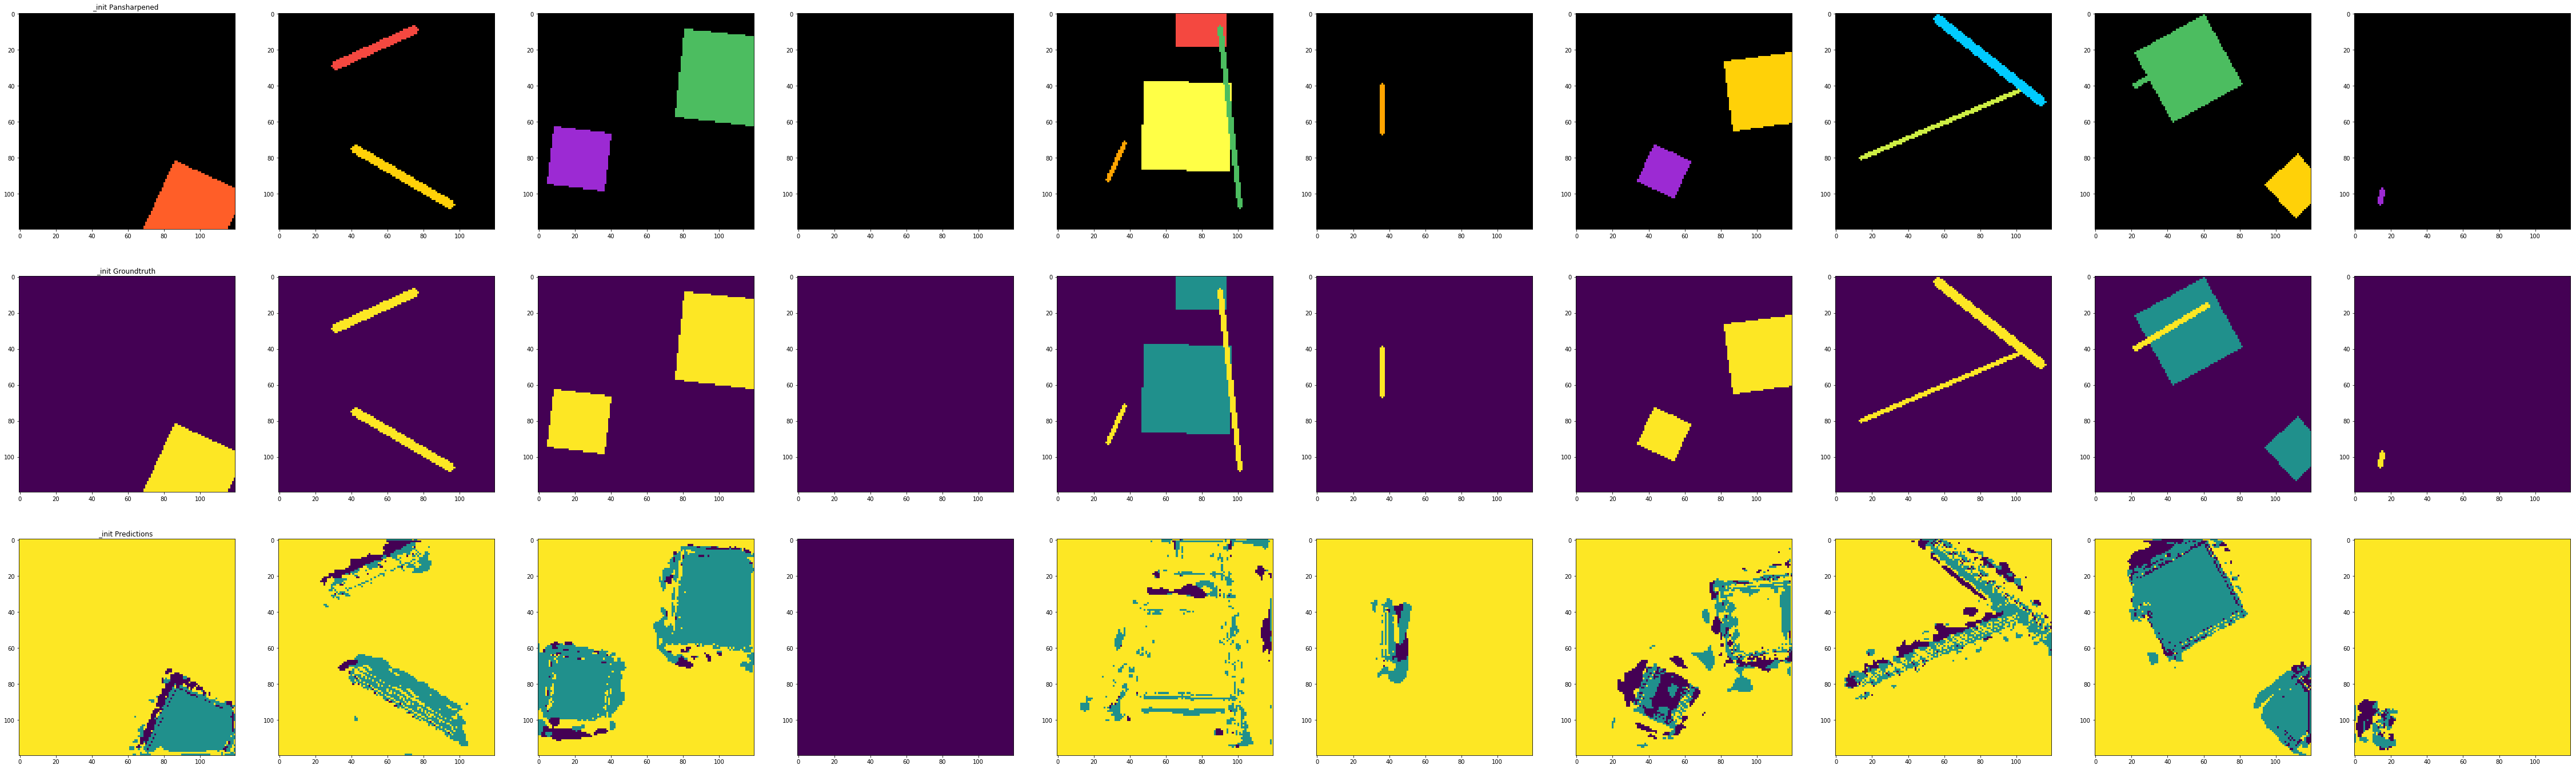

2018-04-07 11:49:00,046 Start optimization
2018-04-07 11:49:00,099 Iter 0, Minibatch Loss= 0.8600, Training Accuracy= 88.5321, Minibatch error= 11.5%
2018-04-07 11:49:04,070 Iter 100, Minibatch Loss= 0.8420, Training Accuracy= 95.9844, Minibatch error= 4.0%
2018-04-07 11:49:08,019 Iter 200, Minibatch Loss= 0.8546, Training Accuracy= 95.7908, Minibatch error= 4.2%
2018-04-07 11:49:11,968 Iter 300, Minibatch Loss= 0.8478, Training Accuracy= 91.4766, Minibatch error= 8.5%
2018-04-07 11:49:15,919 Iter 400, Minibatch Loss= 0.8569, Training Accuracy= 97.6780, Minibatch error= 2.3%
2018-04-07 11:49:19,862 Iter 500, Minibatch Loss= 0.8589, Training Accuracy= 93.8203, Minibatch error= 6.2%
2018-04-07 11:49:23,805 Iter 600, Minibatch Loss= 0.8616, Training Accuracy= 87.1163, Minibatch error= 12.9%
2018-04-07 11:49:24,487 Epoch 0, Average loss: 0.8494, learning rate: 0.0001
2018-04-07 11:49:24,500 Verification error= 4.7%, loss= 0.8461


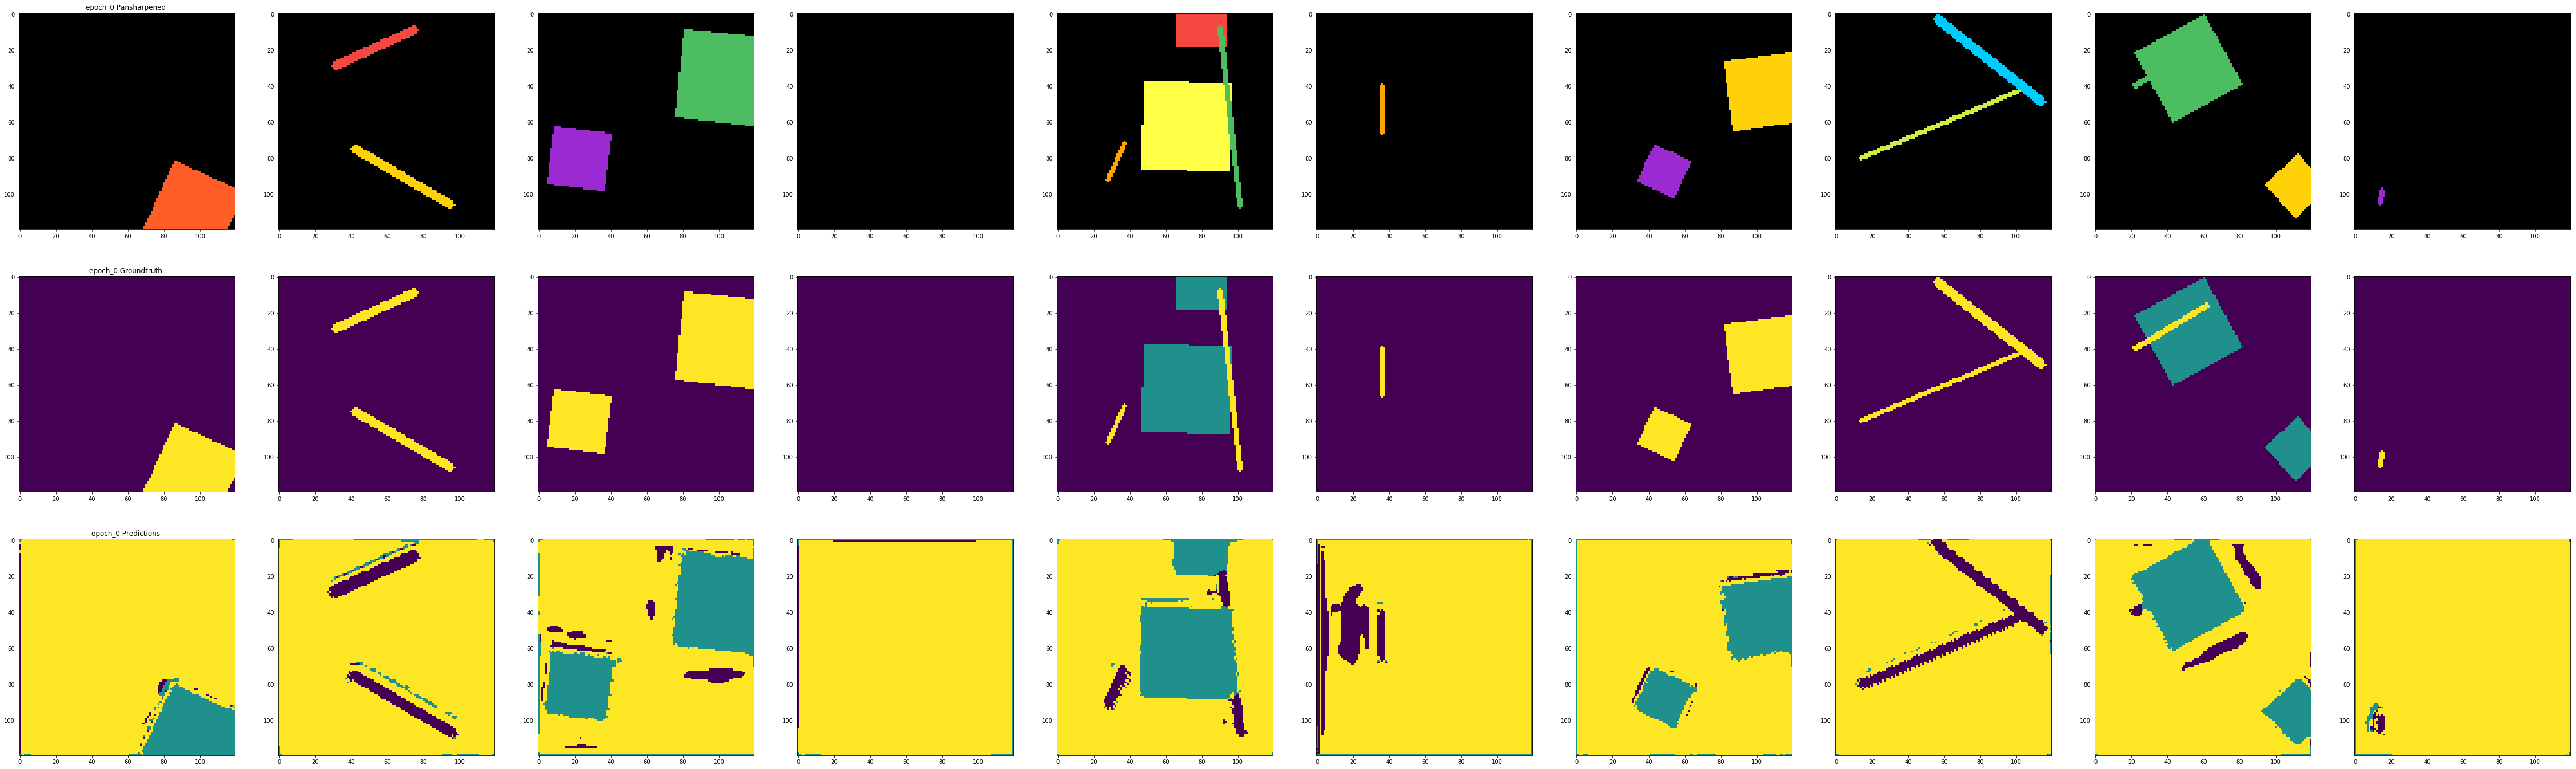

Validation IoU 0.8618%, Validation IoU_acc 100.0000%,Validation F1 IoU 12.4383%


2018-04-07 11:49:31,894 Iter 700, Minibatch Loss= 0.8538, Training Accuracy= 92.7517, Minibatch error= 7.2%
2018-04-07 11:49:35,862 Iter 800, Minibatch Loss= 0.8501, Training Accuracy= 92.8030, Minibatch error= 7.2%
2018-04-07 11:49:39,849 Iter 900, Minibatch Loss= 0.8452, Training Accuracy= 82.4566, Minibatch error= 17.5%
2018-04-07 11:49:43,820 Iter 1000, Minibatch Loss= 0.8486, Training Accuracy= 90.9679, Minibatch error= 9.0%
2018-04-07 11:49:47,793 Iter 1100, Minibatch Loss= 0.8433, Training Accuracy= 80.2700, Minibatch error= 19.7%
2018-04-07 11:49:51,739 Iter 1200, Minibatch Loss= 0.8654, Training Accuracy= 73.0000, Minibatch error= 27.0%
2018-04-07 11:49:53,118 Epoch 1, Average loss: 0.8477, learning rate: 0.0001
2018-04-07 11:49:53,132 Verification error= 34.8%, loss= 0.8458


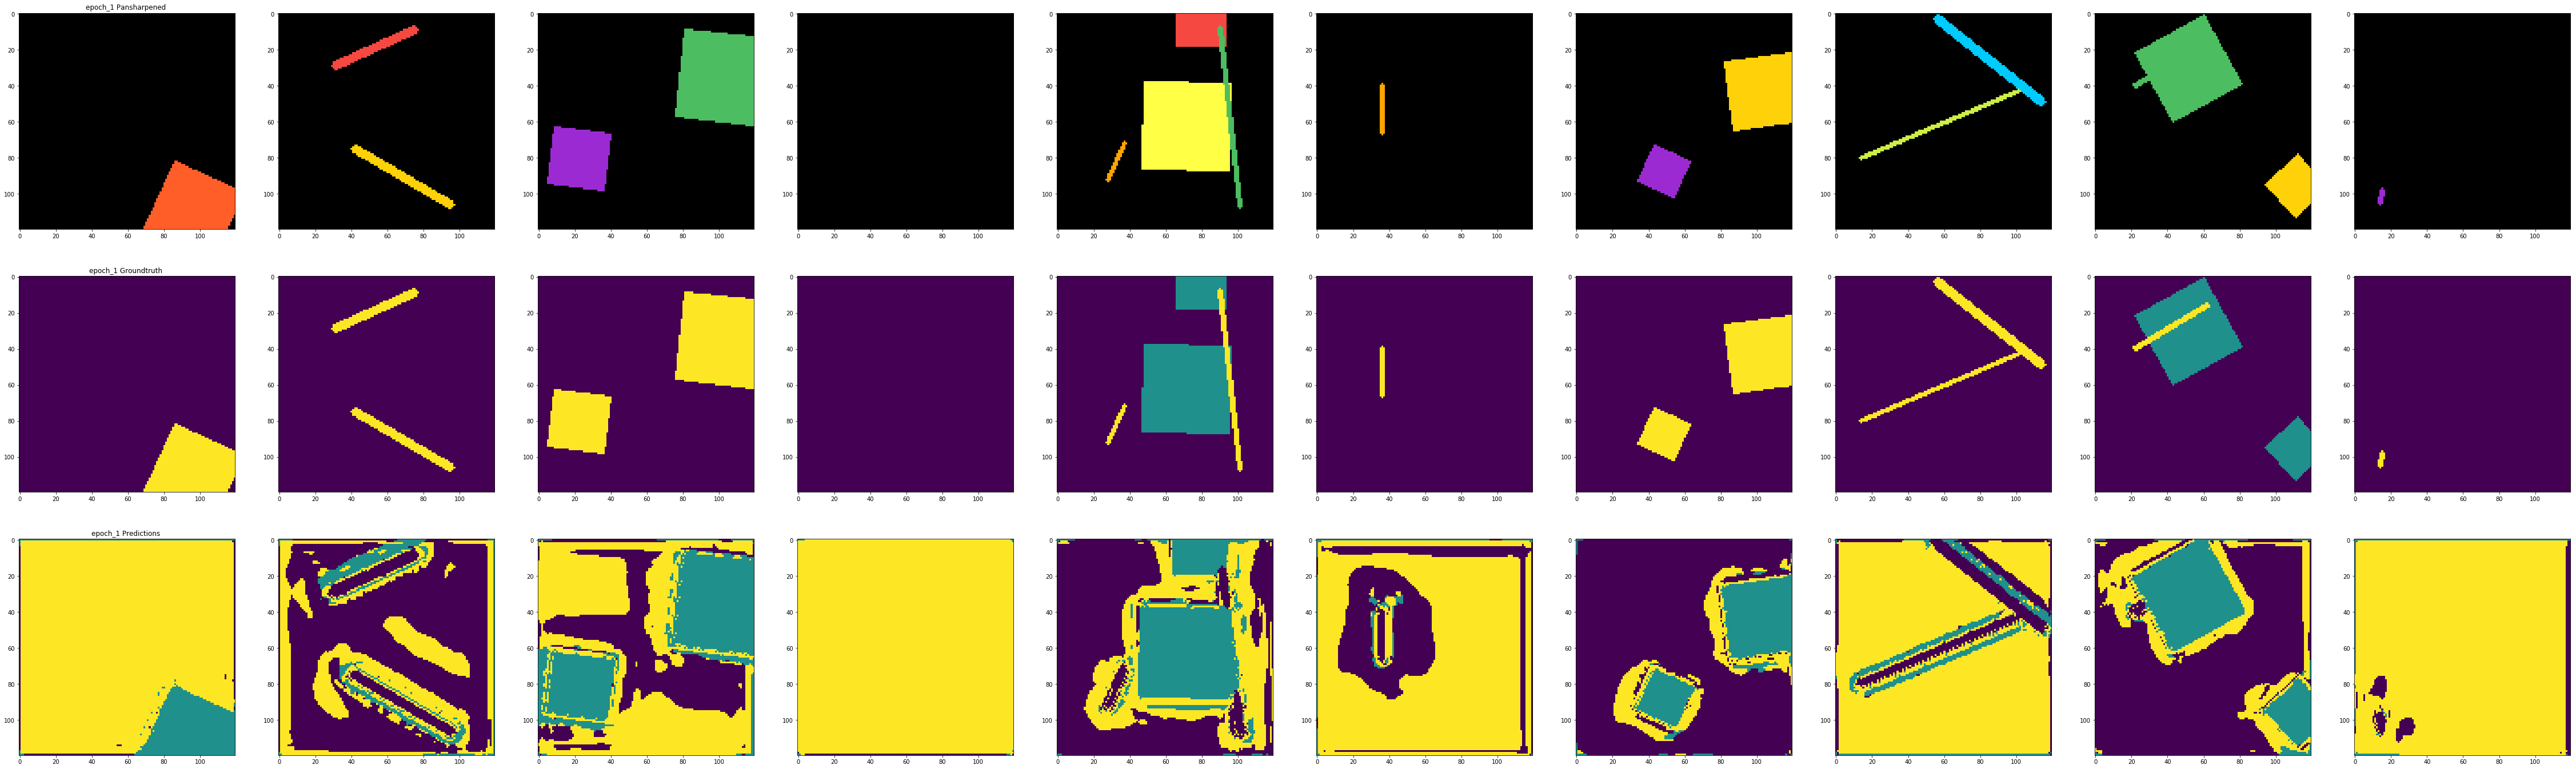

Exception ignored in: <bound method FieldDefn.<lambda> of <osgeo.ogr.FieldDefn; proxy of <Swig Object of type 'OGRFieldDefnShadow *' at 0x7fcb9d7f7c00> >>
Traceback (most recent call last):
  File "/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/osgeo/ogr.py", line 5428, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt


Validation IoU 0.7305%, Validation IoU_acc 90.0000%,Validation F1 IoU 7.0564%


2018-04-07 11:50:03,377 Iter 1300, Minibatch Loss= 0.8492, Training Accuracy= 82.3316, Minibatch error= 17.7%


KeyboardInterrupt: 

In [25]:
if __name__ == '__main__':

    
    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT)
    model.cuda()
    cudnn.benchmark = True
    
    root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'

    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR)
    
    
    save_path,loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train( root_folder, MODEL_PATH_SAVE, MODEL_PATH_RESTORE, DEFAULT_ITERATIONS,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE)
    print('Last model saved is %s: '%save_path)
    #SAVE PSNR
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')
    plt.show()
    
     #SAVE IOU 
    plt.title('Plot IOU', fontsize=20)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(epo,iou_verif,'g')
    plt.ylabel('IOU')
    plt.show()
    
    #SAVE IOU  acc
    plt.title('Plot IOU Accuracy', fontsize=20)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(epo,iou_acc_verif,'g')
    plt.ylabel('IOU Accuracy in %')
    plt.show()

    
     #SAVE f1 IOU
    plt.title('Plot f1 IOU', fontsize=20)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(epo,f1_iou_verif,'g')
    plt.ylabel('f1 IOU in %')
    plt.show()



